In [1]:
import sys
sys.path.append('/Users/lindsaybassman/Documents/LBL/ArQTiC')
from arqtic.simulation_generator import Simulation_Generator
from arqtic.QITE import make_QITE_circ, get_state_from_string
import matplotlib.pyplot as plt
import numpy as np
import qiskit as qk
from qiskit import Aer, IBMQ, execute
from arqtic.arqtic_for_ibm import run_ibm, get_ibm_circuit, add_prog_to_ibm_circuit
from arqtic.program import Program, random_bitstring
import random

In [2]:
#create simulation object
sim_obj = Simulation_Generator("QITE_input.txt")

#Pauli matrices
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sz = np.array([[1, 0], [0, -1]])
#setup inital hamiltonian

T = 100
N = sim_obj.num_spins

msize = 2**N
Jz = sim_obj.Jz #ising interaction strength !!! Not used for 1-qubit
mu_x = sim_obj.h_ext #transverse magnetic field strength
hinit = np.zeros((msize, msize), dtype=np.complex128)
hinit+=Jz*np.kron(sz,sz)
#hinit += -Jz*np.kron(sx,sx)
hinit+=-mu_x*np.kron(sx,np.eye(2))
hinit+=-mu_x*np.kron(np.eye(2),sx)

#Quantum METTS
#set up simulators
qasm_sim = Aer.get_backend('qasm_simulator')
state_vector_sim = Aer.get_backend('statevector_simulator')
backend=qasm_sim
shots = 1024

#create program to move to x-basis for measurement 
prog_xBasis = Program(N)
prog_xBasis.get_x_basis_prog()
xBasis_prep_circ = get_ibm_circuit(state_vector_sim, prog_xBasis, transpile=False)

measured_metts_state = str(np.random.randint(0,2))+str(np.random.randint(0,2))
#for METTS we want to evolve by beta/2 for system at temperature beta
sim_obj.beta = sim_obj.beta/2
#loop over trajectories
eng_array = []
#Es = []
for i in range(T):
    #make IBM circuit
    #Initialization of the circuit
    qr = qk.QuantumRegister(N, name='q')
    # classical 1 bit readout register
    cr = qk.ClassicalRegister(N, name='c')
    # our combined circuit
    qite_circ = qk.QuantumCircuit(qr, cr)
    sim_obj.initial_spins = measured_metts_state
    #note QITE algorithm should evolve state by beta/2 for temperature beta
    qite_circ, energies = make_QITE_circ(sim_obj, qite_circ, regularizer=0.0)
    eng_array.append(energies[-1])
    if (i%2 == 0):
        qite_circ.compose(xBasis_prep_circ, inplace=True)    
    #add measurement operators
    qite_circ.measure(qr, cr)
    #print(len(qite_circ))
    result = qk.execute(qite_circ, qasm_sim, shots=1).result().get_counts()
    for spin_str, count in result.items():
        measured_metts_state = spin_str

In [3]:
#T=100
print(eng_array)
print(np.mean(eng_array))

[-1.4820360937096981, -1.4290198350882095, -1.4820360937096988, -1.4290198350882095, -1.4290198350882086, -1.4290198350882086, -1.4290198350882086, -1.4290198350882086, -1.4290198350882086, -1.4290198350882086, -1.4290198350882095, -1.4820360937096988, -1.4820360937096981, -1.4820360937096988, -1.4290198350882086, -1.4290198350882086, -1.4820360937096981, -1.4820360937096988, -1.4820360937096981, -1.4290198350882095, -1.4290198350882086, -1.4820360937096981, -1.4290198350882086, -1.4290198350882086, -1.4290198350882095, -1.4820360937096988, -1.4290198350882086, -1.4290198350882086, -1.4290198350882086, -1.4290198350882086, -1.4290198350882095, -1.4820360937096981, -1.4290198350882086, -1.4290198350882086, -1.4290198350882086, -1.4290198350882086, -1.4290198350882095, -1.4820360937096988, -1.4820360937096981, -1.4290198350882095, -1.4290198350882095, -1.4820360937096981, -1.4820360937096988, -1.4820360937096981, -1.4820360937096988, -1.4820360937096981, -1.4820360937096988, -1.482036093

In [2]:
#create simulation object
#sim_obj = Simulation_Generator("QITE_input.txt")

In [3]:
#connect to IBM
#if this is your first run enter your API key
#sim_obj.connect_IBM(api_key="c2629e2a2595c888d4b84e5fc15e8756ccf2e3af6f5eb7525beaee93ce017ecb7581cf3c74c8de44a88b2a554ecc7d82be52ac9e358430de782be155e4586195")

In [8]:
#generate circuits
#qcirc, energies = make_QITE_circ(sim_obj, regularizer=0.03)

initial psi is: [0 1 0 0]


No handles with labels found to put in legend.


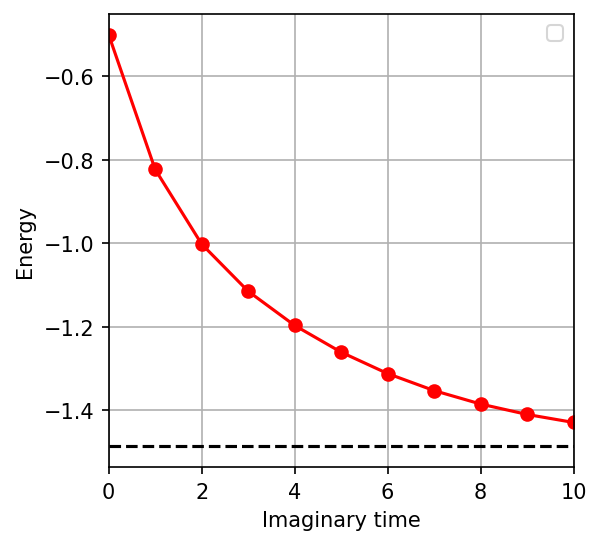

In [12]:
plt.figure(figsize=[4,4], dpi=150)
#plt.plot(np.arange(0,num_beta+1)*dbeta,E,'-ro',label='QITE')
plt.plot(energies,'-ro')
#plt.axhline(y=w[0], color='k',linestyle='--',label="Ground state")
#plt.title("QITE")
plt.xlabel("Imaginary time")
plt.ylabel("Energy")
plt.hlines(-1.4865556615119306, 0, 12, color="black", linestyles='dashed')
plt.grid()
plt.xlim(0,10)

plt.legend(bbox_to_anchor=(1.0,1.0))
#plt.show()
plt.savefig('QITE_GSenergy.png')